In [225]:
import sys
modelkey = 3
sys.argv = [f"--modelversion {modelkey}"]
import multiprocessing

import pandas as pd
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score
from sklearn import utils
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

import config.config as cc
from Functions.original.methods.general.generator import Generator
import torch.nn as nn
import torch
from Functions import metrics
import xgboost as xgb
from sampler import sample
import numpy as np
from itertools import combinations
import Functions.evaluation as ev
import pickle
from sklearn.datasets import fetch_openml

from _1_DataPrep import SpecificPrep, CommonPrep

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [226]:
df = fetch_openml(data_id=41214, as_frame=True).data
common = CommonPrep()
train0, _, test0 = common.fit_transform(df)

In [ ]:
xgb_l = ev.xgb_bootstraped(trainset=train0,
                             testset=test0, bootstraps=4, samplesize=100000, version=1)
ev.summaries(xgb_l)

# Other Section Plots

[Text(0, 0.5, 'N')]

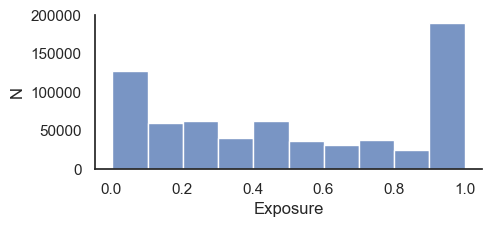

In [272]:
sns.set(rc={'figure.figsize':(5,2)})
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", rc=custom_params)
df1 = df.copy(deep=True).loc[df['Exposure'] <= 1]
ax = sns.histplot(df1['Exposure'], bins=10)
ax.set(ylabel='N')

In [228]:
cc.metadata_ei = cc.load_metadata(metadata_path='./config/metadata.json')
cc.metadata_noei = cc.load_metadata(metadata_path='./config/metadata_noei.json')

In [229]:
datasets = {
    'ei': SpecificPrep(variables = cc.metadata_ei['variables'], gan_cats = cc.metadata_ei['cats_vars_gan'], xgb_cats = cc.metadata_ei['cats_vars_xgb'], addei=True, columns_to_scale = cc.metadata_ei['standardized_vars']),
    'noei': SpecificPrep(variables = cc.metadata_noei['variables'], gan_cats = cc.metadata_noei['cats_vars_gan'], xgb_cats = cc.metadata_noei['cats_vars_xgb'], addei=False, columns_to_scale = cc.metadata_noei['standardized_vars'])
}

for key, trans in datasets.items():
    train = train0.copy(deep=True)
    test = test0.copy(deep=True)
        
    trans = trans.fit(train)
    train = trans.transform(train)
    test = trans.transform(test)
    
    train = trans.inverse_transform(train)
    test = trans.inverse_transform(test)
    
    datasets[key] = {
        'train': train,
        'test': test,
        'transformer': trans
    }

In [6]:
# import os
# # Use to find best model
# models = []
# losses_best = []
# losses_final = []
# for f in os.listdir('./data/losses/'):
#     df = pd.read_csv('./data/losses/'+f)
#     models += [f]
#     losses_best += [df.loc[df['metric_name'] == 'Generated Poisson', 'metric_value'].min()]
#     losses_final += [df.loc[df['metric_name'] == 'Generated Poisson', 'metric_value'].iloc[-1]]
    

# modelslosses = pd.DataFrame({'model': models, 'minloss': losses_best, 'finloss': losses_final})
# modelslosses.sort_values('minloss').head(50)


# Which XGBoost to use

In [198]:
BOOTSTRAPS = 50

In [8]:
# xgb_v1 = ev.xgb_bootstraped(datasets['noei']['train'], datasets['noei']['test'], BOOTSTRAPS, 500000, version=1)
# xgb_v2 = ev.xgb_bootstraped(datasets['noei']['train'], datasets['noei']['test'], BOOTSTRAPS, 500000, version=2)
# [[ev.summaries(x) for x in xgb_v1],
# [ev.summaries(x) for x in xgb_v2]]

In [9]:
# xgb_v1 = ev.xgb_bootstraped(datasets['noei']['train'], datasets['noei']['test'], BOOTSTRAPS, 5000, version=1)
# xgb_v2 = ev.xgb_bootstraped(datasets['noei']['train'], datasets['noei']['test'], BOOTSTRAPS, 5000, version=2)
# [[ev.summaries(x) for x in xgb_v1],
# [ev.summaries(x) for x in xgb_v2]]

Best models:
L: V1
S: V2

# Get GANs

In [13]:
altmodels1 = {
    'H1':   ev.get_model(104, datasets, bestmodel=True), # 22
    'l_ei':   ev.get_model( 22, datasets, bestmodel=True), # 22
    'l_noei': ev.get_model(122, datasets, bestmodel=True),# 104
    's_ei':   ev.get_model(721, datasets, bestmodel=True), # 721
    's_noei': ev.get_model(621, datasets, bestmodel=True) # 621
}

altmodels1['H1']['transformer'].xgb_dummifier.drop_first = False
altmodels1['l_ei']['transformer'].xgb_dummifier.drop_first = False
altmodels1['l_noei']['transformer'].xgb_dummifier.drop_first = False
altmodels1['s_ei']['transformer'].xgb_dummifier.drop_first = False
altmodels1['s_noei']['transformer'].xgb_dummifier.drop_first = False

altmodels1['H1']['boots'] = ev.gan_bootstraped(altmodels1['H1'], datasets['noei']['test'], datasets, BOOTSTRAPS, stratify=True)
print([ev.summaries(altmodels1['H1']['boots'])])

altmodels1['l_ei']['boots'] = ev.gan_bootstraped(altmodels1['l_ei'], datasets['noei']['test'], datasets, BOOTSTRAPS, stratify=True)
print([ev.summaries(altmodels1['l_ei']['boots'])])

altmodels1['l_noei']['boots'] = ev.gan_bootstraped(altmodels1['l_noei'], datasets['noei']['test'], datasets, BOOTSTRAPS, stratify=True)
print([ev.summaries(altmodels1['l_noei']['boots'])])

altmodels1['s_ei']['boots'] = ev.gan_bootstraped(altmodels1['s_ei'], datasets['noei']['test'], datasets, BOOTSTRAPS, version=2, stratify=True)
print([ev.summaries(altmodels1['s_ei']['boots'])])

altmodels1['s_noei']['boots'] = ev.gan_bootstraped(altmodels1['s_noei'], datasets['noei']['test'], datasets, BOOTSTRAPS, version=2, stratify=True)
print([ev.summaries(altmodels1['s_noei']['boots'])])

bestmodels = altmodels1

100%|██████████| 50/50 [07:41<00:00,  9.24s/it]


[(0.317, 0.002, 0.316, 0.318)]


100%|██████████| 50/50 [08:09<00:00,  9.78s/it]


[(0.319, 0.002, 0.319, 0.32)]


100%|██████████| 50/50 [07:39<00:00,  9.18s/it]


[(0.321, 0.002, 0.32, 0.321)]


100%|██████████| 50/50 [04:54<00:00,  5.88s/it]


[(0.372, 0.015, 0.368, 0.377)]


100%|██████████| 50/50 [04:23<00:00,  5.26s/it]

[(0.326, 0.002, 0.326, 0.327)]


# Hypothesis 1.1

In [265]:
devs = []
trainset = datasets['noei']['train'].copy(deep=True)
testset = datasets['noei']['test'].copy(deep=True)
for i in range(0, BOOTSTRAPS):
    train1 = utils.resample(trainset, replace=True, n_samples=len(trainset), random_state=i)
    test1 = utils.resample(testset, replace=True, n_samples=len(testset), random_state=i)
    
    pred_dummy = train1['ClaimNb'].mean()
    
    preds1 = [pred_dummy] * len(test1)
    devs += [metrics.poisson_deviance(pred=preds1, obs=test1['ClaimNb'])]

base_devs = devs

ev.summaries(devs)

(0.319, 0.003, 0.318, 0.32)

In [266]:
stats.ttest_ind(bestmodels['H1']['boots'], base_devs, alternative='less')

Ttest_indResult(statistic=-3.3844494641522562, pvalue=0.0005134455708376021)

# Hypothesis 1.2

In [283]:
xgb_l = ev.xgb_bootstraped(trainset=datasets['noei']['train'],
                             testset=datasets['noei']['test'], bootstraps=BOOTSTRAPS, samplesize=500000, version=1)

100%|██████████| 50/50 [26:53<00:00, 32.28s/it]


In [284]:
ev.summaries(xgb_l)

(0.302, 0.001, 0.301, 0.302)

In [285]:
stats.ttest_ind(bestmodels['H1']['boots'], xgb_l, alternative='two-sided')

Ttest_indResult(statistic=39.788850969275515, pvalue=2.712190147559876e-62)

# Hypothesis 2.1

In [31]:
stats.ttest_ind(bestmodels['l_ei']['boots'], bestmodels['l_noei']['boots'], alternative='less')

Ttest_indResult(statistic=-3.499632372540741, pvalue=0.0003513108286563001)

# Hypothesis 2.2

In [32]:
stats.ttest_ind(bestmodels['s_ei']['boots'], bestmodels['s_noei']['boots'], alternative='less')

Ttest_indResult(statistic=21.222184771474417, pvalue=1.0)

# Plots

## Results Boxplot

In [286]:
sns.set(rc={'figure.figsize':(5,4)})
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)

<Axes: xlabel='Model type', ylabel='Poisson Deviance'>

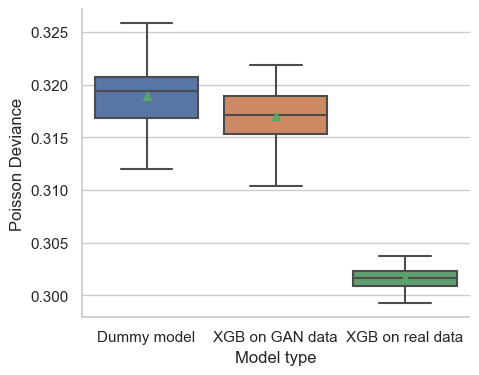

In [287]:
toplot = pd.DataFrame()

#H1
toplot = pd.concat([toplot, pd.DataFrame({'Model type': 'Dummy model', 'Poisson Deviance': base_devs})])
toplot = pd.concat([toplot, pd.DataFrame({'Model type': 'XGB on GAN data', 'Poisson Deviance': bestmodels['H1']['boots']})])
toplot = pd.concat([toplot, pd.DataFrame({'Model type': 'XGB on real data', 'Poisson Deviance': xgb_l})])

sns.boxplot(data=toplot, x='Model type', y='Poisson Deviance', showfliers=False, showmeans=True)

In [35]:
sns.set(rc={'figure.figsize':(3,4)})
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)

<Axes: xlabel='Expert Input', ylabel='Poisson Deviance'>

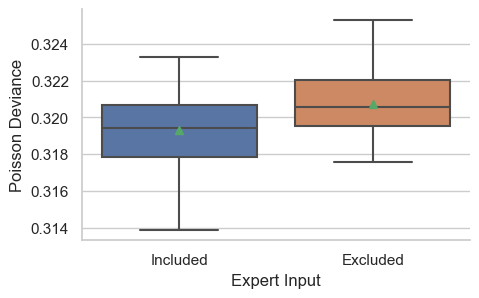

In [273]:
# H2.1
toplot = pd.DataFrame()
sns.set(rc={'figure.figsize':(5,3)})
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)
toplot = pd.concat([toplot, pd.DataFrame({'N of Train set': 433728, 'Expert Input': 'Included', 'Poisson Deviance': bestmodels['l_ei']['boots']})])
toplot = pd.concat([toplot, pd.DataFrame({'N of Train set': 433728, 'Expert Input': 'Excluded', 'Poisson Deviance': bestmodels['l_noei']['boots']})])

sns.boxplot(data=toplot, x='Expert Input', y='Poisson Deviance', showfliers=False, showmeans=True)

<Axes: xlabel='Expert Input', ylabel='Poisson Deviance'>

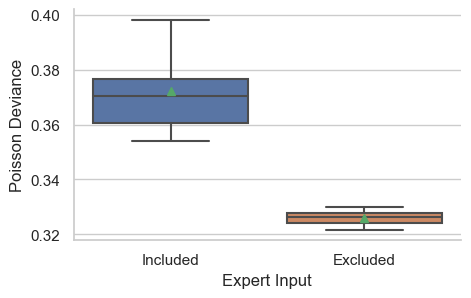

In [274]:
# H2
toplot = pd.DataFrame()
sns.set(rc={'figure.figsize':(5,3)})
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)
toplot = pd.concat([toplot, pd.DataFrame({'N of Train set': 5000, 'Expert Input': 'Included', 'Poisson Deviance': bestmodels['s_ei']['boots']})])
toplot = pd.concat([toplot, pd.DataFrame({'N of Train set': 5000, 'Expert Input': 'Excluded', 'Poisson Deviance': bestmodels['s_noei']['boots']})])

sns.boxplot(data=toplot, x='Expert Input', y='Poisson Deviance', showfliers=False, showmeans=True)

## Decile Plot

In [43]:
preds_l_ei = ev.gan_xgb(metadata=cc.metadata_ei, postprocess=True, testset=datasets['noei']['test'], 
        transformer=datasets['ei']['transformer'], value=bestmodels['l_ei'], seed=1, stratify=True)
preds_l_noei = ev.gan_xgb(metadata=cc.metadata_noei, postprocess=True, testset=datasets['noei']['test'], 
        transformer=datasets['noei']['transformer'], value=bestmodels['l_noei'], seed=1, stratify=True)
preds_s_ei = ev.gan_xgb(metadata=cc.metadata_ei, postprocess=True, testset=datasets['noei']['test'], 
        transformer=datasets['ei']['transformer'], value=bestmodels['s_ei'], seed=1, stratify=True)
preds_s_noei = ev.gan_xgb(metadata=cc.metadata_noei, postprocess=True, testset=datasets['noei']['test'], 
        transformer=datasets['noei']['transformer'], value=bestmodels['s_noei'], seed=1, stratify=True)

In [75]:
sns.set(rc={'figure.figsize':(6,3)})
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)

<Axes: xlabel='Ventile', ylabel='Mean Error'>

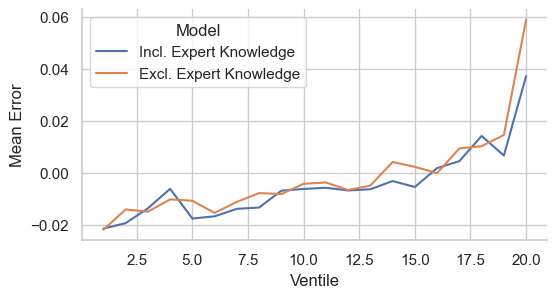

In [78]:
plottest = datasets['noei']['test'].copy(deep=True)
plottest['lei'] = preds_l_ei
plottest['lnoei'] = preds_l_noei
plottest['sei'] = preds_s_ei
plottest['snoei'] = preds_s_noei
plottest['dec_lei'] = pd.qcut(plottest['lei'], q=20, labels=False)
plottest['dec_lei']+=1
plottest['dec_lnoei'] = pd.qcut(plottest['lnoei'], q=20, labels=False)
plottest['dec_lnoei']+=1
plottest['risk_lei'] = (plottest['lei'] - plottest['ClaimNb'])
plottest['risk_lnoei'] = (plottest['lnoei'] - plottest['ClaimNb'])
plottestlei = plottest.groupby('dec_lei', as_index=False)['risk_lei'].mean()
plottestlnoei = plottest.groupby('dec_lnoei', as_index=False)['risk_lnoei'].mean()
plottestlei.columns = ['Ventile', 'Mean Error']
plottestlei['Model'] = 'Incl. Expert Knowledge'
plottestlnoei.columns = ['Ventile', 'Mean Error']
plottestlnoei['Model'] = 'Excl. Expert Knowledge'
toplot = pd.concat([plottestlei, plottestlnoei])

sns.lineplot(data=toplot, x="Ventile", y="Mean Error", hue="Model")


<Axes: xlabel='Ventile', ylabel='Mean Error'>

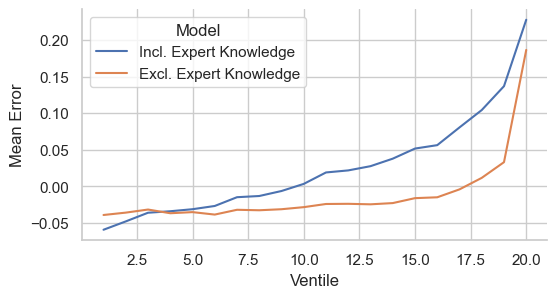

In [79]:
plottest = datasets['noei']['test'].copy(deep=True)
plottest['lei'] = preds_s_ei
plottest['lnoei'] = preds_s_noei
plottest['dec_lei'] = pd.qcut(plottest['lei'], q=20, labels=False)
plottest['dec_lei']+=1
plottest['dec_lnoei'] = pd.qcut(plottest['lnoei'], q=20, labels=False)
plottest['dec_lnoei']+=1
plottest['risk_lei'] = (plottest['lei'] - plottest['ClaimNb'])
plottest['risk_lnoei'] = (plottest['lnoei'] - plottest['ClaimNb'])
plottestlei = plottest.groupby('dec_lei', as_index=False)['risk_lei'].mean()
plottestlnoei = plottest.groupby('dec_lnoei', as_index=False)['risk_lnoei'].mean()
plottestlei.columns = ['Ventile', 'Mean Error']
plottestlei['Model'] = 'Incl. Expert Knowledge'
plottestlnoei.columns = ['Ventile', 'Mean Error']
plottestlnoei['Model'] = 'Excl. Expert Knowledge'
toplot = pd.concat([plottestlei, plottestlnoei])

sns.lineplot(data=toplot, x="Ventile", y="Mean Error", hue="Model")

# GAN with expert input removed after training

In [68]:
ev.run_xgboost(, )

(41.37, 0.14, 0.26, 0.53)

In [ ]:
ev.run_xgboost(models['s_ei']['sample'], datasets['ei']['test'])

In [ ]:
ev.run_xgboost(models['s_ei']['sample'], datasets['ei']['test'])

In [10]:
key = modelkey
value = models_ei[modelkey]

bestmodel = get_model(key, value, bestmodel = True, postprocess =True, keep_ei=False)
ev.run_xgboost(bestmodel['sample'], test_noei)

3:


(34.2, 0.1, 0.24, 0.43)

# GAN with expert input generated by the GAN itself

In [11]:
key = modelkey
value = models_ei[modelkey]

bestmodel = get_model(key, value, bestmodel = True, postprocess =False, keep_ei=True)
bestmodel['sample'] = bestmodel['sample'][test_ei.columns]

ev.run_xgboost(bestmodel['sample'], test_ei)

3:


(35.99, 0.1, 0.24, 0.44)

# GAN with updated expert input

In [12]:
key = modelkey
value = models_ei[modelkey]

bestmodel = get_model(key, value, bestmodel = True, postprocess =False, keep_ei=False)
bestmodel['sample'] = specific_transformer.eier.transform(bestmodel['sample'])
bestmodel['sample'] = bestmodel['sample'][test_ei.columns]

ev.run_xgboost(bestmodel['sample'], test_ei)

3:


(34.1, 0.09, 0.24, 0.42)

In [ ]:
def make_glms(train, test, base_formula = ''):
    # No Input
    formula0 = "ClaimNb ~ 1"
    formula1 = f"ClaimNb ~ {base_formula}  VehPowerGLM + C(VehAgeGLM, Treatment(reference=2)) + C(DrivAgeGLM, Treatment(reference=5)) + BonusMalusGLM + VehGas + DensityGLM + C(Region, Treatment(reference='R24'))"
    formula2 = f"{formula1} + VehBrand"
    formula3 = f"{formula2} + AreaGLM"

    formulas = [formula0, formula1, formula2, formula3]
    devs = []
    
    for formulaa in formulas:
        glm0 = smf.glm(formula=formulaa, data=train, family=sm.families.Poisson(link=sm.families.links.log()), offset=np.log(train['Exposure'])).fit()
        devs += [metrics.poisson_deviance(glm0.predict(test, offset=np.log(test['Exposure'])), test['ClaimNb'])]
    
    assert min(devs) != devs[0], f'Issue with metrics: {dev}; random model predicts best?!'
    return min(devs)
    

In [ ]:
print(
    
    make_glms(train, test),
    make_glms(train, test, base_formula = 'EI_Density + EI_DrivAge + EI_BonusMalus1 + EI_BonusMalus2 + EI_VehAge +'),
    make_glms(train, test, base_formula = 'GDV_Area + GDV_VehAge + GDV_DrivAge + '),
    make_glms(train, test, base_formula = 'GDV_Area + GDV_VehAge + GDV_DrivAge + EI_Density + EI_DrivAge + EI_BonusMalus1 + EI_BonusMalus2 + EI_VehAge +')
)

In [40]:
models_ei[4]['sample_best']

NameError: name 'models_ei' is not defined

<Axes: xlabel='DrivAge'>

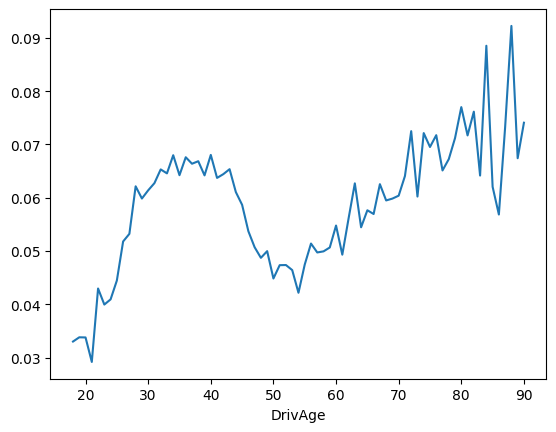

In [157]:
models_ei[3]['sample_final'].groupby('DrivAge')['ClaimNb'].mean().plot()

<Axes: xlabel='DrivAge'>

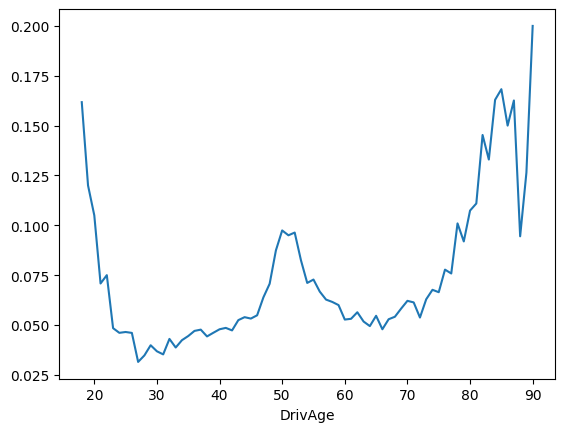

In [155]:
models_ei[4]['sample_final'].groupby('DrivAge')['ClaimNb'].mean().plot()

<Axes: xlabel='DrivAge'>

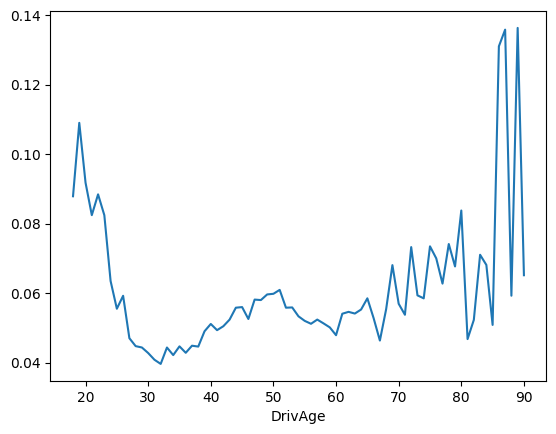

In [149]:
models_ei[4]['train'].groupby('DrivAge')['ClaimNb'].mean().plot()

<Axes: >

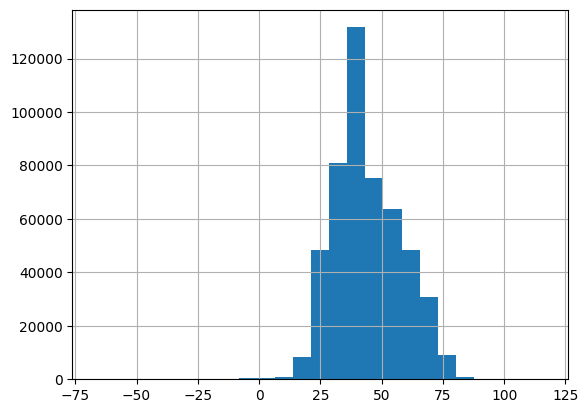

In [137]:
models_ei[4]['train'].groupby('DrivAge')['ClaimNb'].mean().plot()

<Axes: >

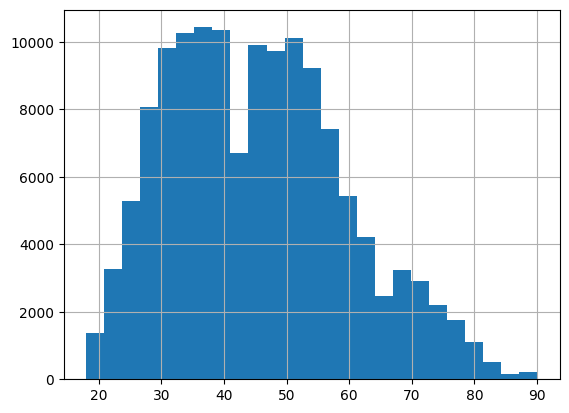

In [124]:
models_ei[4]['test']['DrivAge'].hist(bins=25)

In [64]:
from Functions import metrics
import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective='count:poisson',
                             n_estimators=1200,
                             max_depth=7,
                             eta=0.025,
                             colsample_bytree=0.8,
                             subsample=0.9,
                             min_child_weight=10,
                             tree_method="hist",
                             random_state=1)

xgb_model.fit(train_gan2.drop(labels='ClaimNb', axis=1), train_gan2['ClaimNb'])

preds2 = xgb_model.predict(test1.drop(labels='ClaimNb', axis=1))

dev_mod2 = metrics.poisson_deviance(preds2, test1['ClaimNb'])
dev_base2 = metrics.poisson_deviance([train_gan2['ClaimNb'].mean()] * len(test1), test1['ClaimNb'])
dev_mae2 = mean_absolute_error(test1['ClaimNb'], preds2)
dev_rmse2 = mean_squared_error(test1['ClaimNb'], preds2) ** 0.5

(dev_mod2, dev_base2, dev_mae2, dev_rmse2)

(43.906325984508264, 32.763202082176704, 0.114846262355297, 0.2603551588748538)

In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective='count:poisson',
                             n_estimators=1200,
                             max_depth=7,
                             eta=0.025,
                             colsample_bytree=0.8,
                             subsample=0.9,
                             min_child_weight=10,
                             tree_method="hist",
                             random_state=1)

xgb_model.fit(train1.drop(labels='ClaimNb', axis=1), train1['ClaimNb'])

preds0 = xgb_model.predict(test1.drop(labels='ClaimNb', axis=1))

dev_mod0 = metrics.poisson_deviance(preds0, test1['ClaimNb'])
dev_base0 = metrics.poisson_deviance([train1['ClaimNb'].mean()] * len(test1), test1['ClaimNb'])
dev_mae0 = mean_absolute_error(test1['ClaimNb'], preds0)
dev_rmse0 = mean_squared_error(test1['ClaimNb'], preds0) ** 0.5

(dev_mod0, dev_base0, dev_mae0, dev_rmse0)

In [ ]:
metrics_df = pd.DataFrame({
    'Data type': ['Real data', 'Generated', 'Generated with expert input'],
    'Poisson Deviation': [dev_mod0, dev_mod1, dev_mod2],
    'MAE': [dev_mae0, dev_mae1, dev_mae2],
    'RMSE': [dev_rmse0, dev_rmse1, dev_rmse2]
})

metrics_df

In [ ]:
test1['preds0'] = preds0
test1['preds1'] = preds1
test1['preds2'] = preds2

In [ ]:
test1.groupby('DrivAge')['ClaimNb'].mean().plot()

In [ ]:
test1.groupby('DrivAge')['preds0'].mean().plot()

In [ ]:
test1.groupby('DrivAge')['preds1'].mean().plot()

In [ ]:
test1.groupby('DrivAge')['preds2'].mean().plot()

<Axes: xlabel='DrivAge'>

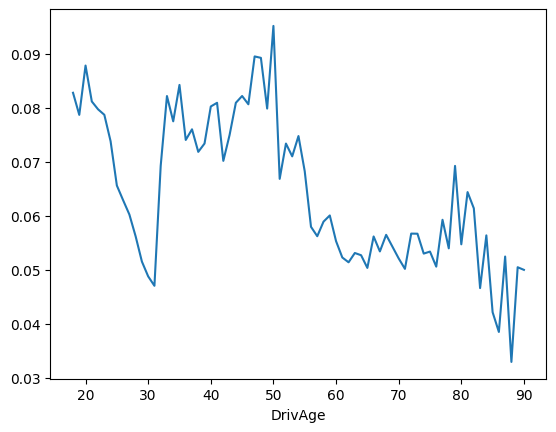

In [77]:
test1.groupby('DrivAge')['preds2'].mean().plot()

In [91]:
# No Input
formula0 = "ClaimNb ~ 1"
formula1 = f"ClaimNb ~   VehPowerGLM + C(VehAgeGLM, Treatment(reference=2)) + C(DrivAgeGLM, Treatment(reference=5)) + BonusMalusGLM + VehGas + DensityGLM + C(Region, Treatment(reference='R24'))"
formula2 = f"{formula1} + VehBrand"
formula3 = f"{formula2} + AreaGLM"



formulas = [formula0, formula1, formula2, formula3]
devs = []

for formulaa in formulas:
    glm0 = smf.glm(formula=formulaa, data=train_gan, family=sm.families.Poisson(link=sm.families.links.log()), offset=np.log(train_gan['Exposure'])).fit()
    devs += [metrics.poisson_deviance(glm0.predict(test, offset=np.log(test['Exposure'])), test['ClaimNb'])]
    print(devs)

[32.91632850254276]
[32.91632850254276, 59.74845410521347]
[32.91632850254276, 59.74845410521347, 59.87506494269026]


TypeError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Object with dtype category cannot perform the numpy op isnan

In [ ]:
Bootstrap(9, n_bootstraps=3, n_train=5, n_test=4, random_state=0)

In [184]:
train1.columns

Index(['ClaimNb', 'VehPower', 'VehAge', 'DrivAge', 'Density', 'BonusMalus',
       'VehBrand_B10', 'VehBrand_B11', 'VehBrand_B12', 'VehBrand_B13',
       'VehBrand_B14', 'VehBrand_B2', 'VehBrand_B3', 'VehBrand_B4',
       'VehBrand_B5', 'VehBrand_B6', 'VehGas_Regular', 'Region_R21',
       'Region_R22', 'Region_R23', 'Region_R24', 'Region_R25', 'Region_R26',
       'Region_R31', 'Region_R41', 'Region_R42', 'Region_R43', 'Region_R52',
       'Region_R53', 'Region_R54', 'Region_R72', 'Region_R73', 'Region_R74',
       'Region_R82', 'Region_R83', 'Region_R91', 'Region_R93', 'Region_R94',
       'Area_2', 'Area_3', 'Area_4', 'Area_5', 'Area_6'],
      dtype='object')